# Filtering a nonlinear system

Here, we define a nonlinear oscillator system where the state is defined as the system's position and velocity. We observe only a nonlinear transformation of the system position and estimate the complete state using an unscented Kalman filter.

In [1]:
import torch
import bside
import matplotlib.pyplot as plt

#### Specify problem parameters

In [12]:
dt = 0.01
qc = 0.1
g = 9.81
xdim = 2
ydim = 1
T = 500
r = 0.1
measure_y0 = False
t = torch.linspace(0, T*dt, T+1)

#### Set up the system of interest

In [13]:
x0 = torch.tensor([1.5, 0.])
Q = bside.PSDMatrix(torch.tensor([[qc * dt**3 / 3, qc * dt**2 / 2], [qc * dt**2 / 2, qc * dt]]))
R = bside.PSDMatrix(torch.tensor([[r**2]]))

def dynamics(x: torch.Tensor, u: torch.Tensor | None = None) -> torch.Tensor:
    return torch.cat([x[:, 0:1] + x[:, 1:2] * dt, x[:, 1:2] - g * torch.sin(x[:, 0:1]) * dt], dim=1)
def measurement(x: torch.Tensor, u: torch.Tensor | None = None) -> torch.Tensor:
    return torch.sin(x[:, 0:1])

dynamics_model = bside.NonlinearAdditiveModel(
    f = dynamics,
    noise_cov = Q,
    in_dim = xdim,
    out_dim = xdim
)
        
observation_model = bside.NonlinearAdditiveModel(
    f = measurement,
    noise_cov = R,
    in_dim = xdim,
    out_dim = ydim
)

sys = bside.SSM(
    xdim = xdim,
    ydim = ydim,
    dynamics = dynamics_model,
    observations = observation_model
)

#### Generate and visualize data

In [14]:
x_true, y = sys.measure(x=x0, T=T, keep_y0=measure_y0, return_x=True)
data = bside.Data(y=y, u=None)

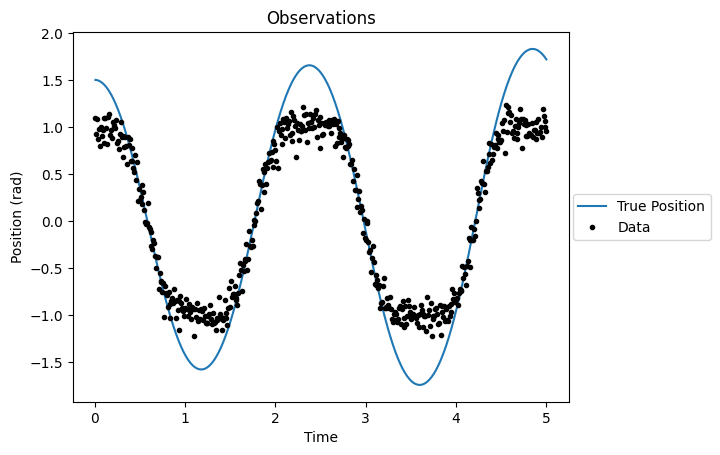

In [5]:
plt.figure()
plt.plot(t if measure_y0 else t[1:], x_true[:, 0], label='True Position')
plt.plot(t if measure_y0 else t[1:], y, 'k.', label='Data')
plt.title('Observations')
plt.xlabel('Time')
plt.ylabel('Position (rad)')
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center right')
plt.show()

#### Set up the filter

In [6]:
P0 = bside.PSDMatrix(0.1*torch.eye(xdim))
init_dist = bside.FilteringDistribution(x0, P0)
filter = bside.UnscentedKalmanFilter(model=sys)

#### Perform and visualize filtering

In [15]:
xf = filter.filter(
    data=data, 
    init_dist=init_dist, 
    y0=measure_y0, 
    return_history=True
)
m_filtered, P_filtered = bside.collate_filtering_distributions(xf)

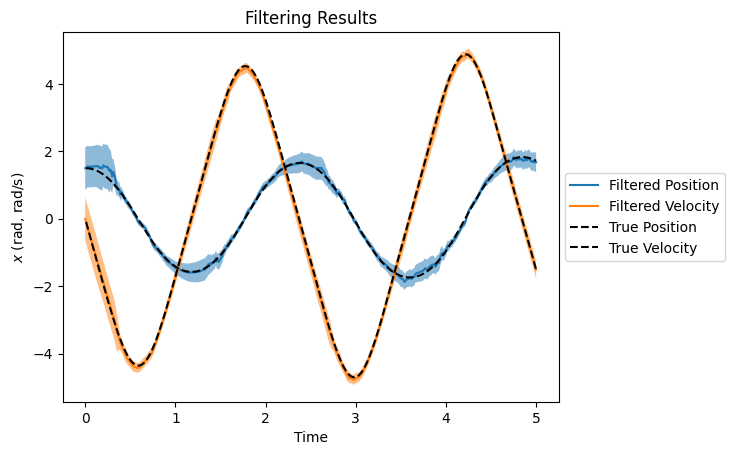

In [16]:
bside.plot_filtering_distributions(m_filtered, P_filtered, t, labels=['Filtered Position', 'Filtered Velocity'])
plt.plot(t[1:], x_true[:, 0], 'k--', label='True Position')
plt.plot(t[1:], x_true[:, 1], 'k--', label='True Velocity')
plt.title('Filtering Results')
plt.xlabel('Time')
plt.ylabel('$x$ (rad, rad/s)')
plt.legend(bbox_to_anchor=(1.35, 0.5), loc='center right')
plt.show()